# Data preparation

## Import base

In [1]:
import pandas as pd

In [2]:
credits = pd.read_csv('tmdb_5000_credits.csv')
movies = pd.read_csv('tmdb_5000_movies.csv')

In [3]:
credits.head()

,movie_id,title,cast,crew
0,19995,Avatar,"[{""cast_id"": 242, ""character"": ""Jake Sully"", ""...","[{""credit_id"": ""52fe48009251416c750aca23"", ""de..."
1,285,Pirates of the Caribbean: At World's End,"[{""cast_id"": 4, ""character"": ""Captain Jack Spa...","[{""credit_id"": ""52fe4232c3a36847f800b579"", ""de..."
2,206647,Spectre,"[{""cast_id"": 1, ""character"": ""James Bond"", ""cr...","[{""credit_id"": ""54805967c3a36829b5002c41"", ""de..."
3,49026,The Dark Knight Rises,"[{""cast_id"": 2, ""character"": ""Bruce Wayne / Ba...","[{""credit_id"": ""52fe4781c3a36847f81398c3"", ""de..."
4,49529,John Carter,"[{""cast_id"": 5, ""character"": ""John Carter"", ""c...","[{""credit_id"": ""52fe479ac3a36847f813eaa3"", ""de..."


In [4]:
movies.head()

,budget,genres,homepage,id,keywords,original_language,original_title,overview,popularity,production_companies,production_countries,release_date,revenue,runtime,spoken_languages,status,tagline,title,vote_average,vote_count
0,237000000,"[{""id"": 28, ""name"": ""Action""}, {""id"": 12, ""nam...",http://www.avatarmovie.com/,19995,"[{""id"": 1463, ""name"": ""culture clash""}, {""id"":...",en,Avatar,"In the 22nd century, a paraplegic Marine is di...",150.437577,"[{""name"": ""Ingenious Film Partners"", ""id"": 289...","[{""iso_3166_1"": ""US"", ""name"": ""United States o...",2009-12-10,2787965087,162.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}, {""iso...",Released,Enter the World of Pandora.,Avatar,7.2,11800
1,300000000,"[{""id"": 12, ""name"": ""Adventure""}, {""id"": 14, ""...",http://disney.go.com/disneypictures/pirates/,285,"[{""id"": 270, ""name"": ""ocean""}, {""id"": 726, ""na...",en,Pirates of the Caribbean: At World's End,"Captain Barbossa, long believed to be dead, ha...",139.082615,"[{""name"": ""Walt Disney Pictures"", ""id"": 2}, {""...","[{""iso_3166_1"": ""US"", ""name"": ""United States o...",2007-05-19,961000000,169.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}]",Released,"At the end of the world, the adventure begins.",Pirates of the Caribbean: At World's End,6.9,4500
2,245000000,"[{""id"": 28, ""name"": ""Action""}, {""id"": 12, ""nam...",http://www.sonypictures.com/movies/spectre/,206647,"[{""id"": 470, ""name"": ""spy""}, {""id"": 818, ""name...",en,Spectre,A cryptic message from Bond’s past sends him o...,107.376788,"[{""name"": ""Columbia Pictures"", ""id"": 5}, {""nam...","[{""iso_3166_1"": ""GB"", ""name"": ""United Kingdom""...",2015-10-26,880674609,148.0,"[{""iso_639_1"": ""fr"", ""name"": ""Fran\u00e7ais""},...",Released,A Plan No One Escapes,Spectre,6.3,4466
3,250000000,"[{""id"": 28, ""name"": ""Action""}, {""id"": 80, ""nam...",http://www.thedarkknightrises.com/,49026,"[{""id"": 849, ""name"": ""dc comics""}, {""id"": 853,...",en,The Dark Knight Rises,Following the death of District Attorney Harve...,112.312950,"[{""name"": ""Legendary Pictures"", ""id"": 923}, {""...","[{""iso_3166_1"": ""US"", ""name"": ""United States o...",2012-07-16,1084939099,165.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}]",Released,The Legend Ends,The Dark Knight Rises,7.6,9106
4,260000000,"[{""id"": 28, ""name"": ""Action""}, {""id"": 12, ""nam...",http://movies.disney.com/john-carter,49529,"[{""id"": 818, ""name"": ""based on novel""}, {""id"":...",en,John Carter,"John Carter is a war-weary, former military ca...",43.926995,"[{""name"": ""Walt Disney Pictures"", ""id"": 2}]","[{""iso_3166_1"": ""US"", ""name"": ""United States o...",2012-03-07,284139100,132.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}]",Released,"Lost in our world, found in another.",John Carter,6.1,2124


In [5]:
movies.columns

Index(['budget', 'genres', 'homepage', 'id', 'keywords', 'original_language',
       'original_title', 'overview', 'popularity', 'production_companies',
       'production_countries', 'release_date', 'revenue', 'runtime',
       'spoken_languages', 'status', 'tagline', 'title', 'vote_average',
       'vote_count'],
      dtype='object')

In [6]:
credits.dtypes
credits.columns

Index(['movie_id', 'title', 'cast', 'crew'], dtype='object')

In [7]:
movies.shape

(4803, 20)

In [8]:
credits.shape

(4803, 4)

In [9]:
# Let's just transform the release date to a datetime type
movies['release_date'] = pd.to_datetime(movies['release_date'])

## Merge credits and movie

In [10]:
# credits and movies have a common column, title, that we need to drop
movies.drop(columns='title', inplace=True)

In [11]:
data = credits.merge(movies, left_on='movie_id', right_on='id')
data.drop(columns='id', inplace=True)

In [12]:
data

,movie_id,title,cast,crew,budget,genres,homepage,keywords,original_language,original_title,...,production_companies,production_countries,release_date,revenue,runtime,spoken_languages,status,tagline,vote_average,vote_count
0,19995,Avatar,"[{""cast_id"": 242, ""character"": ""Jake Sully"", ""...","[{""credit_id"": ""52fe48009251416c750aca23"", ""de...",237000000,"[{""id"": 28, ""name"": ""Action""}, {""id"": 12, ""nam...",http://www.avatarmovie.com/,"[{""id"": 1463, ""name"": ""culture clash""}, {""id"":...",en,Avatar,...,"[{""name"": ""Ingenious Film Partners"", ""id"": 289...","[{""iso_3166_1"": ""US"", ""name"": ""United States o...",2009-12-10,2787965087,162.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}, {""iso...",Released,Enter the World of Pandora.,7.2,11800
1,285,Pirates of the Caribbean: At World's End,"[{""cast_id"": 4, ""character"": ""Captain Jack Spa...","[{""credit_id"": ""52fe4232c3a36847f800b579"", ""de...",300000000,"[{""id"": 12, ""name"": ""Adventure""}, {""id"": 14, ""...",http://disney.go.com/disneypictures/pirates/,"[{""id"": 270, ""name"": ""ocean""}, {""id"": 726, ""na...",en,Pirates of the Caribbean: At World's End,...,"[{""name"": ""Walt Disney Pictures"", ""id"": 2}, {""...","[{""iso_3166_1"": ""US"", ""name"": ""United States o...",2007-05-19,961000000,169.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}]",Released,"At the end of the world, the adventure begins.",6.9,4500
2,206647,Spectre,"[{""cast_id"": 1, ""character"": ""James Bond"", ""cr...","[{""credit_id"": ""54805967c3a36829b5002c41"", ""de...",245000000,"[{""id"": 28, ""name"": ""Action""}, {""id"": 12, ""nam...",http://www.sonypictures.com/movies/spectre/,"[{""id"": 470, ""name"": ""spy""}, {""id"": 818, ""name...",en,Spectre,...,"[{""name"": ""Columbia Pictures"", ""id"": 5}, {""nam...","[{""iso_3166_1"": ""GB"", ""name"": ""United Kingdom""...",2015-10-26,880674609,148.0,"[{""iso_639_1"": ""fr"", ""name"": ""Fran\u00e7ais""},...",Released,A Plan No One Escapes,6.3,4466
3,49026,The Dark Knight Rises,"[{""cast_id"": 2, ""character"": ""Bruce Wayne / Ba...","[{""credit_id"": ""52fe4781c3a36847f81398c3"", ""de...",250000000,"[{""id"": 28, ""name"": ""Action""}, {""id"": 80, ""nam...",http://www.thedarkknightrises.com/,"[{""id"": 849, ""name"": ""dc comics""}, {""id"": 853,...",en,The Dark Knight Rises,...,"[{""name"": ""Legendary Pictures"", ""id"": 923}, {""...","[{""iso_3166_1"": ""US"", ""name"": ""United States o...",2012-07-16,1084939099,165.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}]",Released,The Legend Ends,7.6,9106
4,49529,John Carter,"[{""cast_id"": 5, ""character"": ""John Carter"", ""c...","[{""credit_id"": ""52fe479ac3a36847f813eaa3"", ""de...",260000000,"[{""id"": 28, ""name"": ""Action""}, {""id"": 12, ""nam...",http://movies.disney.com/john-carter,"[{""id"": 818, ""name"": ""based on novel""}, {""id"":...",en,John Carter,...,"[{""name"": ""Walt Disney Pictures"", ""id"": 2}]","[{""iso_3166_1"": ""US"", ""name"": ""United States o...",2012-03-07,284139100,132.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}]",Released,"Lost in our world, found in another.",6.1,2124
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4798,9367,El Mariachi,"[{""cast_id"": 1, ""character"": ""El Mariachi"", ""c...","[{""credit_id"": ""52fe44eec3a36847f80b280b"", ""de...",220000,"[{""id"": 28, ""name"": ""Action""}, {""id"": 80, ""nam...",NaN,"[{""id"": 5616, ""name"": ""united states\u2013mexi...",es,El Mariachi,...,"[{""name"": ""Columbia Pictures"", ""id"": 5}]","[{""iso_3166_1"": ""MX"", ""name"": ""Mexico""}, {""iso...",1992-09-04,2040920,81.0,"[{""iso_639_1"": ""es"", ""name"": ""Espa\u00f1ol""}]",Released,"He didn't come looking for trouble, but troubl...",6.6,238
4799,72766,Newlyweds,"[{""cast_id"": 1, ""character"": ""Buzzy"", ""credit_...","[{""credit_id"": ""52fe487dc3a368484e0fb013"", ""de...",9000,"[{""id"": 35, ""name"": ""Comedy""}, {""id"": 10749, ""...",NaN,[],en,Newlyweds,...,[],

In [13]:
data.set_index('movie_id', inplace=True)

## Removing missing values

In [14]:
data.isna().sum()

title                      0
cast                       0
crew                       0
budget                     0
genres                     0
homepage                3091
keywords                   0
original_language          0
original_title             0
overview                   3
popularity                 0
production_companies       0
production_countries       0
release_date               1
revenue                    0
runtime                    2
spoken_languages           0
status                     0
tagline                  844
vote_average               0
vote_count                 0
dtype: int64

We see that almost all homepages are missing, and as they are not particularly useful, removing completely the column should do. As for the release date and the runtime, we should be able to substitute a reasonable value. The most difficult is going to be working with the missing taglines, but we might end up not using them. 

In [15]:
# Let's take care of the missing release date
data.drop(index=data[data['release_date'].isna()].index, inplace=True)
# This particular movies was too recently released, and everything is missing so we drop it
# It seems that we didn't take into account all the empty lists and null values 

In [16]:
chimameti = data[data['runtime'].isna()].index[0]
frank_sinatra = data[data['runtime'].isna()].index[1]
data.loc[chimameti, 'runtime'] = 113.0
data.loc[frank_sinatra, 'runtime'] = 81.0

We are going to differentiate in addition of the existing data types lists and strings. It's going to be important as the list have subattributes that can be extracted later, but also because the missing value manifests by an empty list which isn't considered NaN by pandas.

In [17]:
data.dtypes

title                           object
cast                            object
crew                            object
budget                           int64
genres                          object
homepage                        object
keywords                        object
original_language               object
original_title                  object
overview                        object
popularity                     float64
production_companies            object
production_countries            object
release_date            datetime64[ns]
revenue                          int64
runtime                        float64
spoken_languages                object
status                          object
tagline                         object
vote_average                   float64
vote_count                       int64
dtype: object

In [18]:
# Let's split the database by column type so that we can search for missing values properly
(data.select_dtypes('number') == 0).sum()

budget          1036
popularity         0
revenue         1426
runtime           34
vote_average      62
vote_count        61
dtype: int64

In [19]:
# Here we split the columns between strings and json 
str_cols, json_cols = [], []
for column in data.select_dtypes('object'):
    if data[column].iloc[0][0] == '[':
        json_cols.append(column)
    else :
        str_cols.append(column)

In [20]:
for column in data[json_cols]:
    data[column] = data[column].map(eval)

In [21]:
(data[json_cols].applymap(len) == 0).sum()

cast                     42
crew                     27
genres                   27
keywords                411
production_companies    350
production_countries    173
spoken_languages         85
dtype: int64

In [22]:
data[str_cols].isna().sum()

title                   0
homepage             3090
original_language       0
original_title          0
overview                3
status                  0
tagline               843
dtype: int64

In [23]:
chimameti_desc = 'A biopic of the rise of father Jorge Mario Bergoglio SJ from a teacher in a Jesuit High School in Argentina to archbishop and cardinal of Buenos Aires to Pope of the Roman Catholic Church. The story touches on his relation with his fellow Jesuits in Argentina and Europe, to his relation with laureate writer Jorge Luis Borges, Argentine dictator Jorge Rafael Videla, and archbishops Laghi (nuncio to Argentina) and Quarracino (cardinal of Buenos Aires), up to the moment where he is elected Pope in 2013'
frank_sinatra_desc = 'The life of Frank Sinatra, as an actor and singer and the steps along the way that led him to become such an icon.'
food_chains_desc = 'There is so much interest in food these days yet there is almost no interest in the hands that pick that food. In the US, farm labor has always been one of the most difficult and poorly paid jobs and has relied on some of the nation\'s most vulnerable people. While the legal restrictions which kept people bound to farms, like slavery, have been abolished, exploitation still exists, ranging from wage theft to modern-day slavery. These days, this exploitation is perpetuated by the corporations at the top of the food chain: supermarkets. Their buying power has kept wages pitifully low and has created a scenario where desperately poor people are willing to put up with anything to keep their jobs.'

In [24]:
data[data['overview'].isna()]

,title,cast,crew,budget,genres,homepage,keywords,original_language,original_title,overview,...,production_companies,production_countries,release_date,revenue,runtime,spoken_languages,status,tagline,vote_average,vote_count
movie_id,,,,,,,,,,,,,,,,,,,,,
370980,Chiamatemi Francesco - Il Papa della gente,"[{'cast_id': 5, 'character': 'Jorge Mario Berg...","[{'credit_id': '5660019ac3a36875f100252b', 'de...",15000000,"[{'id': 18, 'name': 'Drama'}]",NaN,"[{'id': 717, 'name': 'pope'}, {'id': 5565, 'na...",it,Chiamatemi Francesco - Il Papa della gente,NaN,...,"[{'name': 'Taodue Film', 'id': 45724}]","[{'iso_3166_1': 'IT', 'name': 'Italy'}]",2015-12-03,0,113.0,"[{'iso_639_1': 'es', 'name': 'Español'}]",Released,NaN,7.3,12
459488,"To Be Frank, Sinatra at 100","[{'cast_id': 0, 'character': 'Narrator', 'cred...","[{'credit_id': '592b25e4c3a368783e065a2f', 'de...",2,"[{'id': 99, 'name': 'Documentary'}]",NaN,"[{'id': 6027, 'name': 'music'}, {'id': 225822,...",en,"To Be Frank, Sinatra at 100",NaN,...,"[{'name': 'Eyeline Entertainment', 'id': 60343}]","[{'iso_3166_1': 'GB', 'name': 'United Kingdom'}]",2015-12-12,0,81.0,[],Released,NaN,0.0,0
292539,Food Chains,[],"[{'credit_id': '5470c3b1c3a368085e000abd', 'de...",913000,"[{'id': 99, 'name': 'Documentary'}]",NaN,[],de,Food Chains,NaN,...,[],[],2014-04-26,0,83.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,NaN,7.4,8


In [25]:
# Let's fill in manually the missing overviews
data.loc[chimameti, 'overview'] = chimameti_desc
data.loc[frank_sinatra, 'overview'] = frank_sinatra_desc
data.loc[data['overview'].isna(), 'overview'] = food_chains_desc

In [26]:
data.drop(columns='homepage', inplace=True)

We delete the lines where cast or crew is missing because it would be much more work to recover these information and only a few are missing. 

In [27]:
data.drop(index=data[data['crew'].map(len) == 0].index, inplace=True)
data.drop(index=data[data['cast'].map(len) == 0].index, inplace=True)

Now we need to consider all the 'list' missing values. Those are more difficult to handle because they involve ids and conventions from the database. It's relatively easy to scrap imdb but less to match the info we can get there with the ones we already have. We will leave this part for when we have a specific id of our need in terms of missing values. 

## Transforming jsons into lists

We have multiple json columns, which will be more easy to manipulate once transformed into lists. But first let's create a directors column.

In [28]:
json_cols

['cast',
 'crew',
 'genres',
 'keywords',
 'production_companies',
 'production_countries',
 'spoken_languages']

In [29]:
def to_director(crew):
    directors = [crew_member['name'] for crew_member in crew if crew_member['job'] == 'Director']
    return 'NoDirector' if len(directors) == 0 else [directors[0]]

In [30]:
# Some crews contain multiple directors but those are rare, so we will take the first one, and drop the movies without any
data['director'] = data['crew'].apply(to_director)
data.drop(data[data.director == 'NoDirector'].index, inplace=True)

In [31]:
def json_to_list(json):
    return [element['name'] for element in json]

In [32]:
data[json_cols] = data[json_cols].applymap(json_to_list)

In [33]:
data[json_cols].head()

,cast,crew,genres,keywords,production_companies,production_countries,spoken_languages
movie_id,,,,,,,
19995,"[Sam Worthington, Zoe Saldana, Sigourney Weave...","[Stephen E. Rivkin, Rick Carter, Christopher B...","[Action, Adventure, Fantasy, Science Fiction]","[culture clash, future, space war, space colon...","[Ingenious Film Partners, Twentieth Century Fo...","[United States of America, United Kingdom]","[English, Español]"
285,"[Johnny Depp, Orlando Bloom, Keira Knightley, ...","[Dariusz Wolski, Gore Verbinski, Jerry Bruckhe...","[Adventure, Fantasy, Action]","[ocean, drug abuse, exotic island, east india ...","[Walt Disney Pictures, Jerry Bruckheimer Films...",[United States of America],[English]
206647,"[Daniel Craig, Christoph Waltz, Léa Seydoux, R...","[Thomas Newman, Sam Mendes, Anna Pinnock, John...","[Action, Adventure, Crime]","[spy, based on novel, secret agent, sequel, mi...","[Columbia Pictures, Danjaq, B24]","[United Kingdom, United States of America]","[Français, English, Español, Italiano, Deutsch]"
49026,"[Christian Bale, Michael Caine, Gary Oldman, A...","[Hans Zimmer, Charles Roven, Christopher Nolan...","[Action, Crime, Drama, Thriller]","[dc comics, crime fighter, terrorist, secret i...","[Legendary Pictures, Warner Bros., DC Entertai...",[United States of America],[English]
49529,"[Taylor Kitsch, Lynn Collins, Samantha Morton,...","[Andrew Stanton, Andrew Stanton, John Lasseter...","[Action, Adventure, Science Fiction]","[based on novel, mars, medallion, space travel...",[Walt Disney Pictures],[United States of America],[English]


In [34]:
json_cols += 'director'

# Initial analysis

## Descriptive statistics

In [35]:
import ast

In [36]:
import matplotlib.pyplot as plt

In [37]:
import datetime

In [38]:
import numpy as np

In [39]:
import seaborn as sns

In [40]:
# statistical description of the data base
data.describe()

,budget,popularity,revenue,runtime,vote_average,vote_count
count,4.751000e+03,4751.000000,4.751000e+03,4751.000000,4751.000000,4751.000000
mean,2.935914e+07,21.725186,8.315294e+07,107.334877,6.115113,697.741107
std,4.083306e+07,31.911891,1.635206e+08,21.840986,1.125381,1239.217251
min,0.000000e+00,0.000372,0.000000e+00,0.000000,0.000000,0.000000
25%,1.000000e+06,4.925587,0.000000e+00,94.000000,5.600000,57.000000
50%,1.500000e+07,13.244365,1.980000e+07,104.000000,6.200000,241.000000
75%,4.000000e+07,28.609656,9.400000e+07,118.000000,6.800000,749.500000
max,3.800000e+08,875.581305,2.787965e+09,338.000000,10.000000,13752.000000


In [41]:
data.corr()

,budget,popularity,revenue,runtime,vote_average,vote_count
budget,1.000000,0.502854,0.729951,0.266525,0.085049,0.591499
popularity,0.502854,1.000000,0.643519,0.220985,0.279216,0.777276
revenue,0.729951,0.643519,1.000000,0.251017,0.200402,0.780835
runtime,0.266525,0.220985,0.251017,1.000000,0.363222,0.271673
vote_average,0.085049,0.279216,0.200402,0.363222,1.000000,0.323158
vote_count,0.591499,0.777276,0.780835,0.271673,0.323158,1.000000


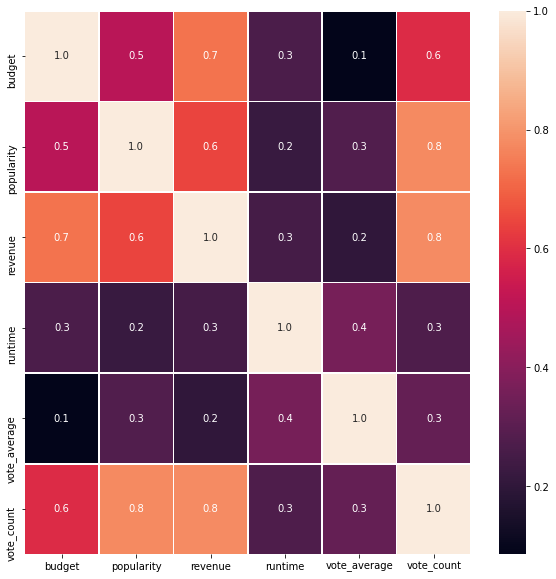

In [42]:
## Correlation map visualisation
f,ax = plt.subplots(figsize = (10,10))
sns.heatmap(data.corr(), annot = True, linewidths=.5, fmt = '.1f', ax = ax)
plt.show()


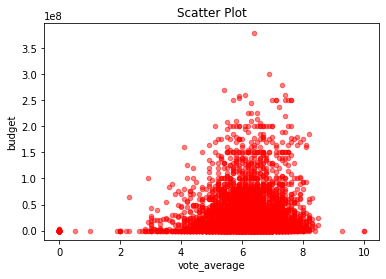

In [43]:
#showing the level of correlation between budget and vote_average using Scatter Plot
data.plot(kind='scatter', x='vote_average', y='budget', alpha=.5, color='r')
plt.xlabel('vote_average')
plt.ylabel('budget')
plt.title('Scatter Plot')
plt.show()

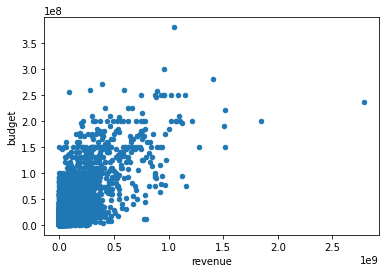

In [44]:
#showing the level of correlation between budget and revenue using Scatter Plot
data.plot(kind = 'scatter', x = 'revenue', y = 'budget')
plt.show()

In [45]:
# we will add a new column 'profit-rate' based on the relation between budget and revenue
data['profit_rate'] = data.revenue / data.budget
data.head()

,title,cast,crew,budget,genres,keywords,original_language,original_title,overview,popularity,...,release_date,revenue,runtime,spoken_languages,status,tagline,vote_average,vote_count,director,profit_rate
movie_id,,,,,,,,,,,,,,,,,,,,,
19995,Avatar,"[Sam Worthington, Zoe Saldana, Sigourney Weave...","[Stephen E. Rivkin, Rick Carter, Christopher B...",237000000,"[Action, Adventure, Fantasy, Science Fiction]","[culture clash, future, space war, space colon...",en,Avatar,"In the 22nd century, a paraplegic Marine is di...",150.437577,...,2009-12-10,2787965087,162.0,"[English, Español]",Released,Enter the World of Pandora.,7.2,11800,[James Cameron],11.763566
285,Pirates of the Caribbean: At World's End,"[Johnny Depp, Orlando Bloom, Keira Knightley, ...","[Dariusz Wolski, Gore Verbinski, Jerry Bruckhe...",300000000,"[Adventure, Fantasy, Action]","[ocean, drug abuse, exotic island, east india ...",en,Pirates of the Caribbean: At World's End,"Captain Barbossa, long believed to be dead, ha...",139.082615,...,2007-05-19,961000000,169.0,[English],Released,"At the end of the world, the adventure begins.",6.9,4500,[Gore Verbinski],3.203333
206647,Spectre,"[Daniel Craig, Christoph Waltz, Léa Seydoux, R...","[Thomas Newman, Sam Mendes, Anna Pinnock, John...",245000000,"[Action, Adventure, Crime]","[spy, based on novel, secret agent, sequel, mi...",en,Spectre,A cryptic message from Bond’s past sends him o...,107.376788,...,2015-10-26,880674609,148.0,"[Français, English, Español, Italiano, Deutsch]",Released,A Plan No One Escapes,6.3,4466,[Sam Mendes],3.594590
49026,The Dark Knight Rises,"[Christian Bale, Michael Caine, Gary Oldman, A...","[Hans Zimmer, Charles Roven, Christopher Nolan...",250000000,"[Action, Crime, Drama, Thriller]","[dc comics, crime fighter, terrorist, secret i...",en,The Dark Knight Rises,Following the death of District Attorney Harve...,112.312950,...,2012-07-16,1084939099,165.0,[English],Released,The Legend Ends,7.6,9106,[Christopher Nolan],4.339756
49529,John Carter,"[Taylor Kitsch, Lynn Collins, Samantha Morton,...","[Andrew Stanton, Andrew Stanton, John Lasseter...",260000000,"[Action, Adventure, Science Fiction]","[based on novel, mars, medallion, space travel...",en,John Carter,"John Carter is a war-weary, former military ca...",43.926995,...,2012-03-07,284139100,132.0,[English],Released,"Lost in our world, found in another.",6.1,2124,[Andrew Stanton],1.092843


## Genres analysis

In [46]:
from collections import Counter

In [47]:
genres = pd.DataFrame.from_dict(dict(Counter(data['genres'].sum())), orient='index').reset_index()
genres.columns=['genre', 'movies']
genres.sort_values(by='movies', inplace=True, ascending=False)
genres

,genre,movies
5,Drama,2290
10,Comedy,1715
6,Thriller,1272
0,Action,1152
11,Romance,892
1,Adventure,790
4,Crime,695
3,Science Fiction,534
12,Horror,518
8,Family,507


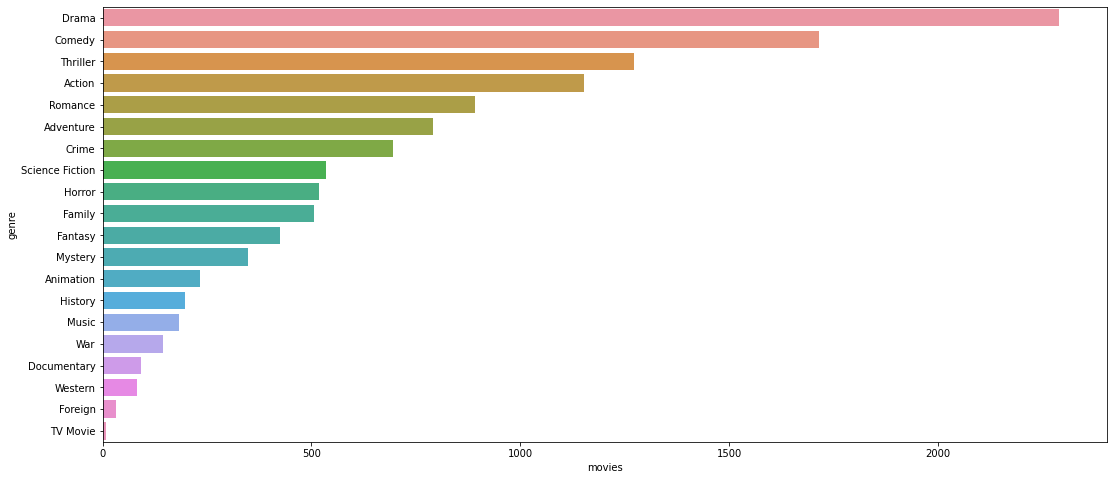

In [48]:
plt.figure(figsize=(18,8))
sns.barplot(x='movies', y='genre', data=genres)
plt.show()

To see the distribution of the genres in our Data Base, it seems to be helpfull not to work with the release_date which gives the exact date of release but rather consider the year of release so that we can group the films by year and see the distribution of the genres

### Genres in history

In [49]:
# To have a better insight on the release_date
data['release_date'].head()

movie_id
19995    2009-12-10
285      2007-05-19
206647   2015-10-26
49026    2012-07-16
49529    2012-03-07
Name: release_date, dtype: datetime64[ns]

In [50]:
# Extrating the year of release
data['year'] = data['release_date'].dt.strftime('%Y')

In [51]:
data.head()

,title,cast,crew,budget,genres,keywords,original_language,original_title,overview,popularity,...,revenue,runtime,spoken_languages,status,tagline,vote_average,vote_count,director,profit_rate,year
movie_id,,,,,,,,,,,,,,,,,,,,,
19995,Avatar,"[Sam Worthington, Zoe Saldana, Sigourney Weave...","[Stephen E. Rivkin, Rick Carter, Christopher B...",237000000,"[Action, Adventure, Fantasy, Science Fiction]","[culture clash, future, space war, space colon...",en,Avatar,"In the 22nd century, a paraplegic Marine is di...",150.437577,...,2787965087,162.0,"[English, Español]",Released,Enter the World of Pandora.,7.2,11800,[James Cameron],11.763566,2009
285,Pirates of the Caribbean: At World's End,"[Johnny Depp, Orlando Bloom, Keira Knightley, ...","[Dariusz Wolski, Gore Verbinski, Jerry Bruckhe...",300000000,"[Adventure, Fantasy, Action]","[ocean, drug abuse, exotic island, east india ...",en,Pirates of the Caribbean: At World's End,"Captain Barbossa, long believed to be dead, ha...",139.082615,...,961000000,169.0,[English],Released,"At the end of the world, the adventure begins.",6.9,4500,[Gore Verbinski],3.203333,2007
206647,Spectre,"[Daniel Craig, Christoph Waltz, Léa Seydoux, R...","[Thomas Newman, Sam Mendes, Anna Pinnock, John...",245000000,"[Action, Adventure, Crime]","[spy, based on novel, secret agent, sequel, mi...",en,Spectre,A cryptic message from Bond’s past sends him o...,107.376788,...,880674609,148.0,"[Français, English, Español, Italiano, Deutsch]",Released,A Plan No One Escapes,6.3,4466,[Sam Mendes],3.594590,2015
49026,The Dark Knight Rises,"[Christian Bale, Michael Caine, Gary Oldman, A...","[Hans Zimmer, Charles Roven, Christopher Nolan...",250000000,"[Action, Crime, Drama, Thriller]","[dc comics, crime fighter, terrorist, secret i...",en,The Dark Knight Rises,Following the death of District Attorney Harve...,112.312950,...,1084939099,165.0,[English],Released,The Legend Ends,7.6,9106,[Christopher Nolan],4.339756,2012
49529,John Carter,"[Taylor Kitsch, Lynn Collins, Samantha Morton,...","[Andrew Stanton, Andrew Stanton, John Lasseter...",260000000,"[Action, Adventure, Science Fiction]","[based on novel, mars, medallion, space travel...",en,John Carter,"John Carter is a war-weary, former military ca...",43.926995,...,284139100,132.0,[English],Released,"Lost in our world, found in another.",6.1,2124,[Andrew Stanton],1.092843,2012


Now that we have the column 'year', the visualisation is easier to code

In [52]:
# we can start by obtaining the range of years in the dataset
# minimum range value
min_year = data['year'].min()
# maximum range value
max_year = data['year'].max()
# print the range
print(min_year, max_year)

1916 2017


## Visualizing text fields

In [53]:
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator

In [54]:
#converting the type of title and overview
data['title'] = data['title'].astype('str')
data['overview'] = data['overview'].astype('str')

In [55]:
title_corpus = ' '.join(data['title'])
overview_corpus = ' '.join(data['overview'])

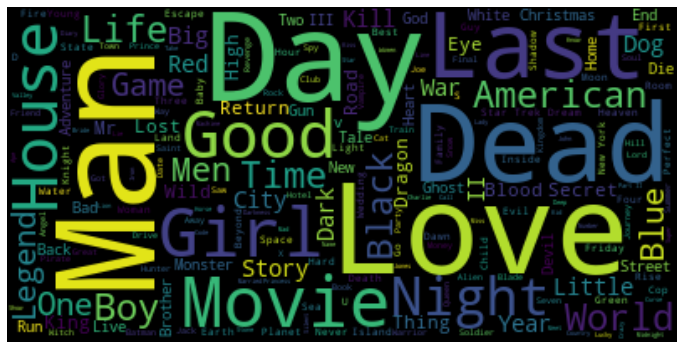

In [56]:
# Creating and generating a word cloud image based on the title:
wordcloud = WordCloud().generate(title_corpus)
plt.figure(figsize=(12,12))# Display the generated image
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

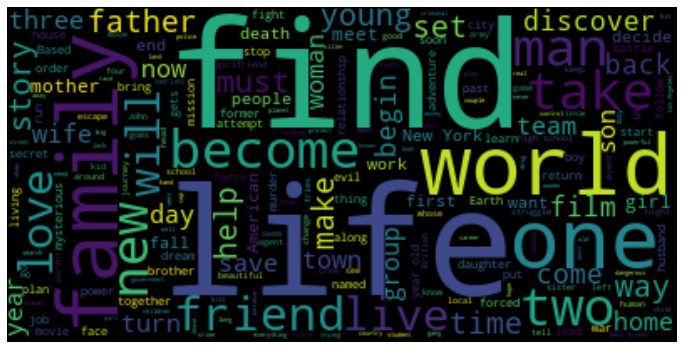

In [57]:
# Creating and generating a word cloud image based on the overview:
wordcloud = WordCloud().generate(overview_corpus)
plt.figure(figsize=(12,12))# Display the generated image
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

# Recommendation systems

Since we only have access to movie data and no user data, we will restrict ourselves to content based filtering. Most platforms today use collaborative filtering, meaning that they recommend content based on what similar users have liked. 

Content based filtering is likely to be less effective, because it is very conservative. You'll only ever be recommended content similar to what you have already liked. Moreover, it wont improve over time.

## Recommendation by rating

We will start with a simple recommendation system which simply recommends the best movies in the database.

In [58]:
# Let's choose the minimum amount of ratings for us to consider the movie
# Here we only take into account movies that have more votes than 80% of the list
min_votes = data['vote_count'].quantile(0.8)
min_votes

966.0

In [59]:
v = data['vote_count']
m = min_votes
R = data['vote_average']
C = data['vote_average'].mean()

In [60]:
data['weighted_rating'] = (v / (v + m) * R) + (m / (v+m) * C)

In [61]:
# The best movies of all time ...
data.sort_values('weighted_rating', ascending=False).head(10)

,title,cast,crew,budget,genres,keywords,original_language,original_title,overview,popularity,...,runtime,spoken_languages,status,tagline,vote_average,vote_count,director,profit_rate,year,weighted_rating
movie_id,,,,,,,,,,,,,,,,,,,,,
278,The Shawshank Redemption,"[Tim Robbins, Morgan Freeman, Bob Gunton, Clan...","[Thomas Newman, Roger Deakins, Philip Ivey, Pe...",25000000,"[Drama, Crime]","[prison, corruption, police brutality, prison ...",en,The Shawshank Redemption,Framed in the 1940s for the double murder of h...,136.747729,...,142.0,[English],Released,Fear can hold you prisoner. Hope can set you f...,8.5,8205,[Frank Darabont],1.133659,1994,8.248795
550,Fight Club,"[Edward Norton, Brad Pitt, Meat Loaf, Jared Le...","[Arnon Milchan, Michael Kaplan, Art Linson, Al...",63000000,[Drama],"[support group, dual identity, nihilism, rage ...",en,Fight Club,A ticking-time-bomb insomniac and a slippery s...,146.757391,...,139.0,[English],Released,Mischief. Mayhem. Soap.,8.3,9413,[David Fincher],1.600853,1999,8.096647
238,The Godfather,"[Marlon Brando, Al Pacino, James Caan, Richard...","[Francis Ford Coppola, Francis Ford Coppola, G...",6000000,"[Drama, Crime]","[italy, love at first sight, loss of father, p...",en,The Godfather,"Spanning the years 1945 to 1955, a chronicle o...",143.659698,...,175.0,"[English, Italiano, Latin]",Released,An offer you can't refuse.,8.4,5893,[Francis Ford Coppola],40.844402,1972,8.078204
680,Pulp Fiction,"[John Travolta, Samuel L. Jackson, Uma Thurman...","[Quentin Tarantino, Quentin Tarantino, Lawrenc...",8000000,"[Thriller, Crime]","[transporter, brothel, drug dealer, boxer, mas...",en,Pulp Fiction,"A burger-loving hit man, his philosophical par...",121.463076,...,154.0,"[English, Español, Français]",Released,Just because you are a character doesn't mean ...,8.3,8428,[Quentin Tarantino],26.741095,1994,8.075325
155,The Dark Knight,"[Christian Bale, Heath Ledger, Aaron Eckhart, ...","[Lucinda Syson, Hans Zimmer, Charles Roven, Ch...",185000000,"[Drama, Action, Crime, Thriller]","[dc comics, crime fighter, secret identity, sc...",en,The Dark Knight,Batman raises the stakes in his war on crime. ...,187.322927,...,152.0,"[English, 普通话]",Released,Why So Serious?,8.2,12002,[Christopher Nolan],5.430046,2008,8.044695
13,Forrest Gump,"[Tom Hanks, Robin Wright, Gary Sinise, Mykelti...","[Alan Silvestri, Robert Zemeckis, Winston Groo...",55000000,"[Comedy, Drama, Romance]","[vietnam veteran, hippie, mentally disabled, r...",en,Forrest Gump,A man with a low IQ has accomplished great thi...,138.133331,...,142.0,[English],Released,"The world will never be the same, once you've ...",8.2,7927,[Robert Zemeckis],12.326280,1994,7.973530
27205,Inception,"[Leonardo DiCaprio, Joseph Gordon-Levitt, Elle...","[Hans Zimmer, Christopher Nolan, Christopher N...",160000000,"[Action, Thriller, Science Fiction, Mystery, A...","[loss of lover, dream, kidnapping, sleep, subc...",en,Inception,"Cobb, a skilled thief who commits corporate es...",167.583710,...,148.0,"[English, 日本語, Français]",Released,Your mind is the scene of the crime.,8.1,13752,[Christopher Nolan],5.159580,2010,7.969724
157336,Interstellar,"[Matthew McConaughey, Jessica Chastain, Anne H...","[Hans Zimmer, Christopher Nolan, Christopher N...",165000000,"[Adventure, Drama, Science Fiction]","[saving the world, artificial intelligence, fa...",en,Interstellar,Interstellar chronicles the adventures of a gr...,724.247784,...,169.0,[English],Released,Mankind was born on Earth. It was never meant ...,8.1,10867,[Christopher Nolan],4.091636,2014,7.937962
1891,The Empire Strikes Back,"[Mark Hamill, Harrison Ford, Carrie Fisher, Bi...","[George Lucas, George Lucas, George Lucas, Gar...",18000000,"[Adventure, Action, Science Fiction]","[rebel, android, asteroid, space battle, snow ...",en,The Empire Strikes Back,"The epic saga continues as Luke Skywalker, in ...",78.517830,...,124.0,[English],Released,The Adventure Continues...,8.2,5879,[Irvin Kershner],29.911111,1980,7.905770


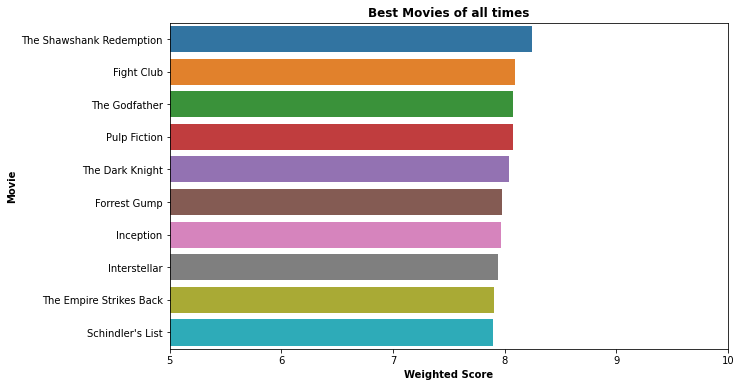

In [62]:
weight_average=data.sort_values('weighted_rating',ascending=False)
plt.figure(figsize=(10,6))
axis1=sns.barplot(x=weight_average['weighted_rating'].head(10), y=weight_average['original_title'].head(10), data=weight_average)
plt.xlim(5, 10)
plt.title('Best Movies of all times', weight='bold')
plt.xlabel('Weighted Score', weight='bold')
plt.ylabel('Movie', weight='bold');

In [63]:
# Which is not the same as if we sort by popularity
data.sort_values('popularity', ascending=False).head(10)

,title,cast,crew,budget,genres,keywords,original_language,original_title,overview,popularity,...,runtime,spoken_languages,status,tagline,vote_average,vote_count,director,profit_rate,year,weighted_rating
movie_id,,,,,,,,,,,,,,,,,,,,,
211672,Minions,"[Sandra Bullock, Jon Hamm, Michael Keaton, All...","[Christopher Meledandri, Kyle Balda, Ken Dauri...",74000000,"[Family, Animation, Adventure, Comedy]","[assistant, aftercreditsstinger, duringcredits...",en,Minions,"Minions Stuart, Kevin and Bob are recruited by...",875.581305,...,91.0,[English],Released,"Before Gru, they had a history of bad bosses",6.4,4571,[Kyle Balda],15.631499,2015,6.350298
157336,Interstellar,"[Matthew McConaughey, Jessica Chastain, Anne H...","[Hans Zimmer, Christopher Nolan, Christopher N...",165000000,"[Adventure, Drama, Science Fiction]","[saving the world, artificial intelligence, fa...",en,Interstellar,Interstellar chronicles the adventures of a gr...,724.247784,...,169.0,[English],Released,Mankind was born on Earth. It was never meant ...,8.1,10867,[Christopher Nolan],4.091636,2014,7.937962
293660,Deadpool,"[Ryan Reynolds, Morena Baccarin, Ed Skrein, T....","[Ronna Kress, Sala Baker, Lauren Shuler Donner...",58000000,"[Action, Adventure, Comedy]","[anti hero, mercenary, marvel comic, superhero...",en,Deadpool,Deadpool tells the origin story of former Spec...,514.569956,...,108.0,[English],Released,Witness the beginning of a happy ending,7.4,10995,[Tim Miller],13.501948,2016,7.296229
118340,Guardians of the Galaxy,"[Chris Pratt, Zoe Saldana, Dave Bautista, Vin ...","[Craig Wood, Christopher Boyes, Christopher Bo...",170000000,"[Action, Science Fiction, Adventure]","[marvel comic, spaceship, space, outer space, ...",en,Guardians of the Galaxy,"Light years from Earth, 26 years after being a...",481.098624,...,121.0,[English],Released,All heroes start somewhere.,7.9,9742,[James Gunn],4.548992,2014,7.738980
76341,Mad Max: Fury Road,"[Tom Hardy, Charlize Theron, Nicholas Hoult, H...","[Iain Smith, Ronna Kress, Bruce Berman, John S...",150000000,"[Action, Adventure, Science Fiction, Thriller]","[future, chase, post-apocalyptic, dystopia, au...",en,Mad Max: Fury Road,An apocalyptic story set in the furthest reach...,434.278564,...,120.0,[English],Released,What a Lovely Day.,7.2,9427,[George Miller],2.525722,2015,7.099163
135397,Jurassic World,"[Chris Pratt, Bryce Dallas Howard, Irrfan Khan...","[Steven Spielberg, John Papsidera, Frank Marsh...",150000000,"[Action, Adventure, Science Fiction, Thriller]","[monster, dna, tyrannosaurus rex, velociraptor...",en,Jurassic World,Twenty-two years after the events of Jurassic ...,418.708552,...,124.0,[English],Released,The park is open.,6.5,8662,[Colin Trevorrow],10.090192,2015,6.461383
22,Pirates of the Caribbean: The Curse of the Bla...,"[Johnny Depp, Geoffrey Rush, Orlando Bloom, Ke...","[Arthur Schmidt, Dariusz Wolski, Klaus Badelt,...",140000000,"[Adventure, Fantasy, Action]","[exotic island, blacksmith, east india trading...",en,Pirates of the Caribbean: The Curse of the Bla...,"Jack Sparrow, a freewheeling 17th-century pira...",271.972889,...,143.0,[English],Released,Prepare to be blown out of the water.,7.5,6985,[Gore Verbinski],4.678652,2003,7.331744
119450,Dawn of the Planet of the Apes,"[Andy Serkis, Jason Clarke, Gary Oldman, Keri ...","[Kevin Mangan, Debra Zane, Doug Jackson, Willi...",170000000,"[Science Fiction, Action, Drama, Thriller]","[leader, colony, post-apocalyptic, dystopia, f...",en,Dawn of the Planet of the Apes,A group of scientists in San Francisco struggl...,243.791743,...,130.0,[English],Released,One last chance for peace.,7.3,4410,[Matt Reeves],4.180262,2014,7.087091
131631,The Hunger Games: Mockingjay - Part 1,"[Jennifer Lawrence, Josh Hutcherson, Liam Hems...","[Debra Zane, James Newton Howard, Philip Seymo...",125000000,"[Science Fiction, Adventure, Thriller]","[resistance, post-apocalyptic, dystopia, war, ...",en,The Hunger Games: Mockingjay - Part 1,Katniss Everdeen reluctantly becomes

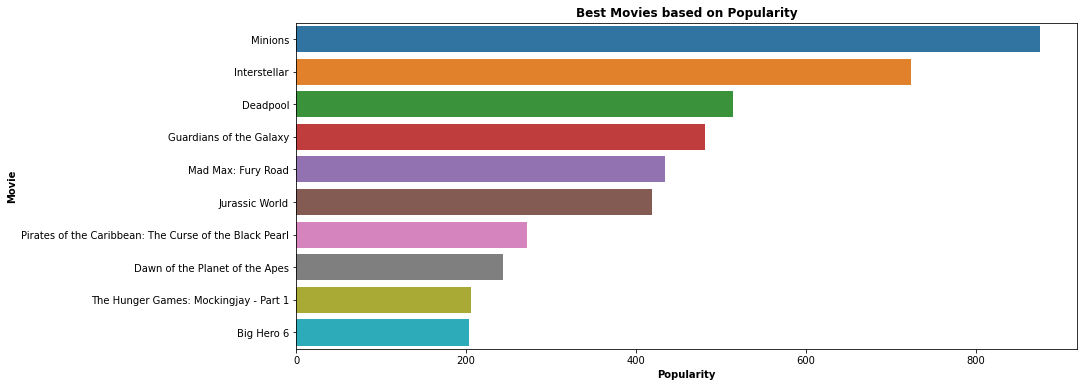

In [64]:
weight_popularity=data.sort_values('popularity',ascending=False)
plt.figure(figsize=(14,6))
axis1=sns.barplot(x=weight_popularity['popularity'].head(10), y=weight_popularity['original_title'].head(10), data=weight_popularity);
plt.title('Best Movies based on Popularity', weight='bold')
plt.xlabel('Popularity', weight='bold')
plt.ylabel('Movie', weight='bold');

A rating and recommendation system based on votes or popularity alone is not very effective nor very interesting, because it's not personnalised at all. So let's see what makes movies close to each other.

## Recommendation based on genre and quality 

We can make another simple recommendation system which is more personnalised. Given a movie, this recommendation system will score all other movies in terms of genre proximity and rating. It will give us back the movies with the best score ! This system is very simple but can be extended quite easily to the keyword category and make an overall not so simple recommendation system.

In [65]:
data.head(1)['genres']

movie_id
19995    [Action, Adventure, Fantasy, Science Fiction]
Name: genres, dtype: object

In [66]:
def genre_proximity(movie1, movie2):
    genres1, genres2 = movie1.genres.iloc[0], movie2.genres
    common_genres = [genre for genre in genres1 if genre in genres2]
    return 2 * len(common_genres)/(len(genres1) + len(genres2))

We have a measure of genre proximity. As it is pretty simple and we can expect many different movies to have the same genres, we should improve it by recommending the best rated movies with the same genres.

In [67]:
def recommend_by_genre(movie_name):
    movie = data[data['title'] == movie_name]
    sub_data = data.drop(index=movie.index) 
    sub_data['proximity'] = sub_data.apply(lambda x: genre_proximity(movie, x), axis=1)
    sub_data.sort_values(['proximity', 'weighted_rating'], ascending=False, inplace=True)
    return sub_data.head(5)['title']

In [68]:
recommend_by_genre('The Dark Knight Rises')

movie_id
155      The Dark Knight
111             Scarface
64690              Drive
2034        Training Day
9509         Man on Fire
Name: title, dtype: object

## Recommendation by description proximity

### With TFID

We are going to vectorize the 'overview' text in order to compute the similarity between different overviews. This recommendation system will recommend movies that are closest based on overview similarity.

Since we will be working with ordered numpy matrices here, it will be easier to reinstate a normal index for the dataframe.

In [69]:
indexed_data = data.reset_index()

In [70]:
from sklearn.feature_extraction.text import TfidfVectorizer

In [71]:
vect = TfidfVectorizer(min_df=1, stop_words='english')
tfidf = vect.fit_transform(indexed_data.overview)
pairwise_similarity = tfidf * tfidf.T

In [72]:
def overview_proximity(movie1, movie2):
    index1, index2 = movie1.index, movie2.index
    return pairwise_similarity[index1][index2]

In [73]:
def overview_recommend(movie_name):
    movie_index = indexed_data[indexed_data.title == movie_name].index
    indexed_data['overview_prox'] = pd.DataFrame(pairwise_similarity.toarray()[movie_index].T)
    return indexed_data.sort_values(by='overview_prox', ascending=False).drop(index=movie_index).head(10).title

In [74]:
overview_recommend('The Dark Knight Rises')

65                              The Dark Knight
299                              Batman Forever
428                              Batman Returns
1359                                     Batman
3850    Batman: The Dark Knight Returns, Part 2
119                               Batman Begins
2507                                  Slow Burn
9            Batman v Superman: Dawn of Justice
1181                                        JFK
210                              Batman & Robin
Name: title, dtype: object

We can see that this method is fancy but not necessarily better than the more simple genre recommendation, because it tends to recommand movies which have the same specific vocabulary (such as here, the same hero). It is not necessarily an indicator of similarity.

### With Word2vec

In [75]:
from gensim.models.doc2vec import Doc2Vec, TaggedDocument
import nltk
nltk.download('punkt')

[nltk_data] Downloading package punkt to /Users/Mathilde/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [76]:
tokenized_overviews = data.overview.apply(nltk.word_tokenize)
tokenized_overviews

movie_id
19995     [In, the, 22nd, century, ,, a, paraplegic, Mar...
285       [Captain, Barbossa, ,, long, believed, to, be,...
206647    [A, cryptic, message, from, Bond, ’, s, past, ...
49026     [Following, the, death, of, District, Attorney...
49529     [John, Carter, is, a, war-weary, ,, former, mi...
                                ...                        
9367      [El, Mariachi, just, wants, to, play, his, gui...
72766     [A, newlywed, couple, 's, honeymoon, is, upend...
231617    [``, Signed, ,, Sealed, ,, Delivered, '', intr...
126186    [When, ambitious, New, York, attorney, Sam, is...
25975     [Ever, since, the, second, grade, when, he, fi...
Name: overview, Length: 4751, dtype: object

In [78]:
corpus = [TaggedDocument(doc, [i]) for i, doc in tokenized_overviews.iteritems()]
model2 = Doc2Vec(corpus, vector_size=100, window=5, min_count=3, workers=4, epochs=10)

In [79]:
model2.docvecs.most_similar(0)

[(140335, 0.4325615167617798),
 (261938, 0.42889225482940674),
 (315113, 0.4223051369190216),
 (35489, 0.4189820885658264),
 (256450, 0.4175110459327698),
 (370017, 0.41559088230133057),
 (264317, 0.41202449798583984),
 (130546, 0.4082275629043579),
 (122210, 0.40553659200668335),
 (327819, 0.4034038186073303)]

In [80]:
def overview_recommend2(movie_name):
    movie_index = data[data.title == movie_name].index
    most_similar = model2.docvecs.most_similar(movie_index)
    recommended = [data.loc[movie[0]].title for movie in most_similar]
    return recommended

In [82]:
overview_recommend2('The Dark Knight')

['Who Killed the Electric Car?',
 "I'm Not There.",
 'Star Trek: The Motion Picture',
 'Freddy vs. Jason',
 'Sorcerer',
 'Killing Them Softly',
 'The Rock',
 'Gridiron Gang',
 'Planet of the Apes',
 'Fast Five']

It's a little bit more difficult to identify how well the recommendation system is performing because the movies are less well known. However some choices seem to be a little off, and other right on spot. It's to be expected since the writing of the overview depends both on the topic of the movie and on the style of the writer (some might be telling the plot, while other focus on describing the ambience for instance).

## Clustering-based recommendation system

### Clustering-specific data cleaning

Let's encode the fields for the columns with mutiple labels binarily

In [76]:
def generate_modality_list(json_col):
    modality_list = list(set(data[json_col].sum()))
    return modality_list

In [77]:
def binarize(char_list, modality_list):
    binary_list = [int(modality in char_list) for modality in modality_list]
    return binary_list

In [84]:
for column in ['genres', 'keywords', 'director']:
    modality_list = generate_modality_list(column)
    data[column + '_bin'] = data[column].apply(lambda x : binarize(x, modality_list))

We can argue that among the columns, the main characteristics that influence the proximity of two movies are the genre, keywords and director. Let's work with these first.

In [86]:
prediction_columns = ['director_bin', 'genres_bin', 'keywords_bin']

In [87]:
from scipy import spatial

In [107]:
def similarity(movie1, movie2):
    director_sim = spatial.distance.cosine(movie1.director_bin, movie2.director_bin)
    genre_sim = spatial.distance.cosine(movie1.genres_bin, movie2.genres_bin)
    keyword_sim = spatial.distance.cosine(movie1.keywords_bin, movie2.keywords_bin)
    return director_sim + genre_sim + keyword_sim

In [129]:
def similarity_recommend(movie_name):
    movie = data[data['title'] == movie_name]
    sub_data = data.drop(index=movie.index) 
    sub_data['similarity'] = sub_data.apply(lambda x: similarity(movie.iloc[0], x), axis=1)
    sub_data.sort_values(['similarity', 'weighted_rating'], ascending=[True, False], inplace=True)
    return sub_data.head(5)['title']

In [130]:
avatar = data[data['title'] == 'Avatar'].iloc[0]
spectre = data[data['title'] == 'Spectre'].iloc[0]

In [131]:
similarity(avatar, spectre)

2.4226497308103743

In [132]:
similarity_recommend('Avatar')

/Users/Mathilde/Documents/projects/projet_info/.venv/lib/python3.9/site-packages/scipy/spatial/distance.py:714: RuntimeWarning: invalid value encountered in double_scalars
  dist = 1.0 - uv / np.sqrt(uu * vv)


movie_id
2756                      The Abyss
679                          Aliens
280      Terminator 2: Judgment Day
218                  The Terminator
36955                     True Lies
Name: title, dtype: object

This technique seems to work quite well since the movies are quite similar without being identical, but there's a hudge bonus to having the same director, which is problematic.